# Hypothesis
- 전문가 데이터(professionals.csv) professionals의 answers 로 professionals의 industry와 headline을 예측할 수 있다
- 이 문제는 Multi-Labeled Classification (Not multi-class classification)

# Work Flow
- professionals의 industry와 headline 데이터를 나름의 카테고리로 전처리한다. (2)
- Answer의 Text를 TF-idf(문장 내에 단어 가중치를 준다) & tokenizing(Reference 찾아보기로) → 하여 Answer의 명사만 뽑는다. (3)
- Answer의 author_id와 professinals_id를 mapping 해주고, 2번에서 전처리한 Answer의 Text를 Input data, 1번에서 전처리한 professionals의 카테고리를 target으로 하여 예측모델을 만든다. (4)
- 예측 모델로 professionals의 industry와 headline의 NA 값을 예측한다. (NA 값 처리 → Softmax(Classifier)) (5)
- Questions + tags(정규표현식으로 전처리)를 조합(어떻게 조합할지도 고민)하여 questions의 Text를 TF-idf(문장 내에 단어 가중치를 준다) & tokenizing 하여 키워드를 추출한다. (6)
- 추출된 키워드가 input, professionals의 industry와 headline이 target 값으로 하여 분류기를 만든다. (어떤 모델일지는 더 고민) (7)

# Expected Result
- Data → Model 1 → Model 2 → Output(Result)
- Model 1 : Answer를 Tokenizing 해주는 모델. 즉, 의미있는 키워드를 추출하는 모델
- Model 2 : 추출된 키워드를 통해 professional의 industry와 headline을 분류해주는 모델 → 결과적으로 industry, headline 분류를 통해 professional 몇 명을 추려내주는 모델

# 해결해야 할 문제
- 여러개의 answer중에 적절한 answer는? → 1대1인 것만 뽑아서 해보자. (1)

# 모델 향상을 위한 제안
- 우리가 전처리한 카테고리 내에서 professinals의 industry와 headline을 고를 수 있도록 항목을 추가

# 데이터 인사이트
- 1대多인 데이터가 양질의 데이터일 것이다.

# TeamMate
- 경욱/유리

## Idea 1: Questions-Answers 매칭하기
- Idea 1 : questions_title에 있는 명사만 tokenizing으로 뽑아내서 professional_industry와 연결짓기
- Idea 2 : questions_body에서 NER(개체명인식)을 통해 중요한 개체를 찾아서 TF-idf 돌리기 => 유사한 질문목록 

## Idea 2: Answers의 글에서 명사/동사 Hashtags를 뽑아서 전문가별 Hashtags 만들기
- 이후 Tags와 연계하여 새로운 Questions와 매칭
- 전문가의 위치(location)/산업(industry)에 따라 질문의 해시태그로 1차 분류

## Idea 3: Tags 상위를 띄워서 홈페이지에 올리기
- Idea: 태그들 top10으로 띄워서 웹페이지에서 해당 태그 누르면 자동으로 해당 top 질문-답변 볼 수 있게 하는 것은 어떨까?

## Idea 4: Groups의 특징을 파악해서 Questions의 Token과 상관관계 뽑기

## Idea 5: Professional과 Student의 상관관계 확인
- 오프라인 매칭(발전방향)
- 향후에 professional이랑 같은 위치인 사람들끼리 오프라인 매칭 시켜주는 것도 좋을 듯?
- data_join에 따라 태그가 어떻게 변화하는지 확인해보는 것도 좋을 듯

### 목차
1. [Data Load](#dataload)
2. [EDA](#eda)
3. [Analyze](#analyze)
4. [Analyze2](#analyze2)

### 1.  <a id="dataload"> Data Load </a>

In [94]:
import pandas as pd
import numpy as np
import os
from os import chdir
import sys
import re 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # 시각화 패키지

In [3]:
chdir('C:/Users/lady1/Desktop/Career/대내외활동/2019/190323- CareerVilage Kaggle/Data/data-science-for-good-careervillage')

In [4]:
answers = pd.read_csv('answers.csv')
comments = pd.read_csv('comments.csv')
emails = pd.read_csv("emails.csv")
group_memberships = pd.read_csv('group_memberships.csv')
groups = pd.read_csv('groups.csv')
matches = pd.read_csv('matches.csv')
professionals = pd.read_csv("professionals.csv")
questions = pd.read_csv('questions.csv')
school_memberships = pd.read_csv('school_memberships.csv')
students = pd.read_csv('students.csv')
tag_questions = pd.read_csv("tag_questions.csv")
tag_users = pd.read_csv('tag_users.csv')
tags = pd.read_csv('tags.csv')

## 2. <a id="eda"> EDA </a>

### 2-1. Answers

In [37]:
answers.head()

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
0,4e5f01128cae4f6d8fd697cec5dca60c,36ff3b3666df400f956f8335cf53e09e,332a511f1569444485cf7a7a556a5e54,2016-04-29 19:40:14 UTC+0000,<p>Hi!</p>\n<p>You are asking a very interesti...
1,ada720538c014e9b8a6dceed09385ee3,2aa47af241bf42a4b874c453f0381bd4,eb80205482e4424cad8f16bc25aa2d9c,2018-05-01 14:19:08 UTC+0000,<p>Hi. I joined the Army after I attended coll...
2,eaa66ef919bc408ab5296237440e323f,cbd8f30613a849bf918aed5c010340be,eb80205482e4424cad8f16bc25aa2d9c,2018-05-02 02:41:02 UTC+0000,"<p>Dear Priyanka,</p><p>Greetings! I have answ..."
3,1a6b3749d391486c9e371fbd1e605014,7e72a630c303442ba92ff00e8ea451df,4ec31632938a40b98909416bdd0decff,2017-05-10 19:00:47 UTC+0000,<p>I work for a global company who values high...
4,5229c514000446d582050f89ebd4e184,17802d94699140b0a0d2995f30c034c6,2f6a9a99d9b24e5baa50d40d0ba50a75,2017-10-13 22:07:33 UTC+0000,I agree with Denise. Every single job I've had...


In [39]:
answers.answers_body[1] # html 태그 없애야 할 듯 

"<p>Hi. I joined the Army after I attended college and received a Bachelor's Degree in Criminal Justice.  Commissioned officers enter the Military with a four year degree or receive officer training after joining and complete a tour. You can prepare yourself by taking Reserve Officer Training Corps (ROTC) while in high school or a university. You can also attend Officer Candidate School (OCS) after graduating from college or become commissioned by earning a professional degree. If you decide to earn a degree, think about what you would like to do while in the military.  The experience in the military was very rewarding. I wish you well and much success in your future. </p>"

In [11]:
answers.describe()

,answers_id,answers_author_id,answers_question_id,answers_date_added,answers_body
count,51123,51123,51123,51123,51122
unique,51123,10169,23110,51062,50401
top,ab0e04a3d71e4e6f8ef0b97a1eb8d26a,36ff3b3666df400f956f8335cf53e09e,8eb6ba7af57846acbfec5633e537192a,2016-10-13 00:52:24 UTC+0000,"<p>&lt;span style=""background-color: transpare..."
freq,1,1710,58,2,103


- 답변 갯수는 51122개
- answers_author_id의 unique값이 1/5로 줄어드는 것을 보아, 전문가가 여러번 답변함

- 답변한 사람들의 텍스트로 저자의 키워드를 해시태그로 뽑아내야 할 것 같음. 
##### 이후 해당 해시태그가 새로운 질문에 들어갈 경우, 해당 해시태그를 많이 답변해준 전문가에게 연결해야할 듯 보임.


### 2-2. Comments

In [12]:
comments.head()

,comments_id,comments_author_id,comments_parent_content_id,comments_date_added,comments_body
0,f30250d3c2ca489db1afa9b95d481e08,9fc88a7c3323466dbb35798264c7d497,b476f9c6d9cd4c50a7bacdd90edd015a,2019-01-31 23:39:40 UTC+0000,"First, you speak to recruiters. They are train..."
1,ca9bfc4ba9464ea383a8b080301ad72c,de2415064b9b445c8717425ed70fd99a,ef4b6ae24d1f4c3b977731e8189c7fd7,2019-01-31 20:30:47 UTC+0000,Most large universities offer study abroad pro...
2,c354f6e33956499aa8b03798a60e9386,6ed20605002a42b0b8e3d6ac97c50c7f,ca7a9d7a95df471c816db82ee758f57d,2019-01-31 18:44:04 UTC+0000,"First, I want to put you at ease that the oppo..."
3,73a6223948714c5da6231937157e4cb7,d02f6d9faac24997a7003a59e5f34bd3,c7a88aa76f5f49b0830bfeb46ba17e4d,2019-01-31 17:53:28 UTC+0000,Your question submission was great! I just wan...
4,55a89a9061d44dd19569c45f90a22779,e78f75c543e84e1c94da1801d8560f65,c7a88aa76f5f49b0830bfeb46ba17e4d,2019-01-31 14:51:53 UTC+0000,Thank you. I'm new to this site. I'm sorry if ...


In [40]:
comments.comments_body[1]

"Most large universities offer study abroad programs.  The study abroad programs are found on the schools website.  You may have to click into the Undergraduate or Graduate links.   I also recommend reaching out to the university counselors.  The have wealth of information and details that may not be on the website. \r\n\r\nMy son will be studying in France and Sweden next year through DePaul University.   The University of Southern California has a very strong international program in which most students participate.  It's a great opportunity to learn the culture of other countries while in school."

In [13]:
comments.describe()

,comments_id,comments_author_id,comments_parent_content_id,comments_date_added,comments_body
count,14966,14966,14966,14966,14962
unique,14966,4231,9923,14905,11963
top,09fad9fdb89b4b7493e9328513ee279c,36ff3b3666df400f956f8335cf53e09e,4c6ae4bd2136472899c15b798eb9d3df,2016-07-22 22:13:05 UTC+0000,Thank you!
freq,1,317,30,3,388


- 코멘트 아이디 통해서 코멘트 많이 다는 사람들을 알 수 있지 않을까

### 2-3. Emails(보류)

In [14]:
emails.head()

,emails_id,emails_recipient_id,emails_date_sent,emails_frequency_level
0,2337714,0c673e046d824ec0ad0ebe012a0673e4,2018-12-07 01:05:40 UTC+0000,email_notification_daily
1,2336077,0c673e046d824ec0ad0ebe012a0673e4,2018-12-06 01:14:15 UTC+0000,email_notification_daily
2,2314660,0c673e046d824ec0ad0ebe012a0673e4,2018-11-17 00:38:27 UTC+0000,email_notification_daily
3,2312639,0c673e046d824ec0ad0ebe012a0673e4,2018-11-16 00:32:19 UTC+0000,email_notification_daily
4,2299700,0c673e046d824ec0ad0ebe012a0673e4,2018-11-08 00:16:40 UTC+0000,email_notification_daily


In [15]:
emails.describe() 

,emails_id
count,1.850101e+06
mean,1.362206e+06
std,6.449917e+05
min,1.060000e+02
25%,8.813900e+05
50%,1.400010e+06
75%,1.911846e+06
max,2.409829e+06


### 2-4. Group_memberships

In [16]:
group_memberships.head()

,group_memberships_group_id,group_memberships_user_id
0,eabbdf4029734c848a9da20779637d03,9a5aead62c344207b2624dba90985dc5
1,eabbdf4029734c848a9da20779637d03,ea7122da1c7b4244a2184a4f9f944053
2,eabbdf4029734c848a9da20779637d03,cba603f34acb4a40b3ccb53fe6681b5d
3,eabbdf4029734c848a9da20779637d03,fa9a126e63714641ae0145557a390cab
4,eabbdf4029734c848a9da20779637d03,299da113c5d1420ab525106c242c9429


In [17]:
group_memberships.describe()

,group_memberships_group_id,group_memberships_user_id
count,1038,1038
unique,46,727
top,f16d593910bf443598839021bbe97128,b0f6c44506444fb99e910dcc5836b5d8
freq,117,14


### 2-5. Groups

In [18]:
groups.head()

,groups_id,groups_group_type
0,eabbdf4029734c848a9da20779637d03,youth program
1,7080bf8dcf78463bb03e6863887fd715,youth program
2,bc6fc50a2b444efc8ec47111b290ffb8,youth program
3,37f002e8d5e442ca8e36e972eaa55882,youth program
4,52419ff84d4b47bebd0b0a6c1263c296,youth program


In [43]:
groups.groups_group_type.unique() 

array(['youth program', 'cause', 'professional network', 'club',
       'competition', 'mentorship program', 'interest group'],
      dtype=object)

In [19]:
groups.describe()

,groups_id,groups_group_type
count,49,49
unique,49,7
top,2db32f76e5524d57ace1012aa9fe1125,youth program
freq,1,33


##### 특정 프로그램을 통해 group_type이 결정되는 듯. 그룹끼리의 연관성이 있는지도 파악해볼 것

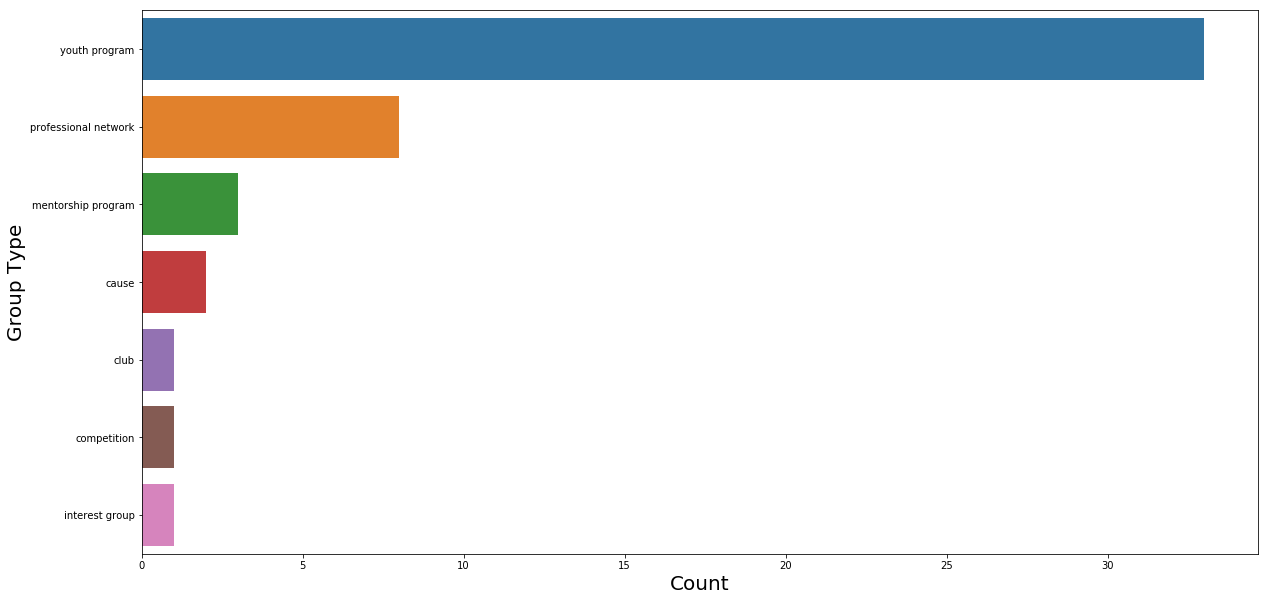

In [20]:
sorted_groups = groups['groups_group_type'].value_counts()
plt.figure(figsize=(20,10))
sns.barplot(sorted_groups.values,sorted_groups.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Group Type", fontsize=20)
plt.show()

### 2-6. Matches

In [20]:
matches.head()

,matches_email_id,matches_question_id
0,1721939,332a511f1569444485cf7a7a556a5e54
1,1665388,332a511f1569444485cf7a7a556a5e54
2,1636634,332a511f1569444485cf7a7a556a5e54
3,1635498,332a511f1569444485cf7a7a556a5e54
4,1620298,332a511f1569444485cf7a7a556a5e54


In [21]:
matches.describe()

,matches_email_id
count,4.316275e+06
mean,1.478192e+06
std,5.895280e+05
min,1.060000e+02
25%,1.011924e+06
50%,1.544656e+06
75%,1.970642e+06
max,2.409829e+06


### 2-7. Professionals

In [22]:
professionals.head()

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,NaN,2011-10-05 20:35:19 UTC+0000
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,2011-10-05 20:49:21 UTC+0000
2,0c673e046d824ec0ad0ebe012a0673e4,"New York, New York",NaN,NaN,2011-10-18 17:31:26 UTC+0000
3,977428d851b24183b223be0eb8619a8c,"Boston, Massachusetts",NaN,NaN,2011-11-09 20:39:29 UTC+0000
4,e2d57e5041a44f489288397c9904c2b2,NaN,NaN,NaN,2011-12-10 22:14:44 UTC+0000


In [51]:
print('location:', professionals.professionals_location.unique())

print('Industry:', professionals.professionals_industry.unique())

location: [nan 'New York, New York' 'Boston, Massachusetts' ...
 'Kingston, Washington' 'Berwyn, Illinois' 'Woodland, California']
Industry: [nan 'Special Events' 'education, tech, media' ... 'Dev Sec Ops'
 'Electrical engineering Computer Software' 'Mobility and Entertainment']


In [23]:
professionals.describe()

,professionals_id,professionals_location,professionals_industry,professionals_headline,professionals_date_joined
count,28152,25054,25576,26085,28152
unique,28152,2582,2470,22272,28000
top,668311ec0dbb4c1db6d5d8fb4e3d7e7e,"New York, New York",Telecommunications,--,2011-12-26 05:00:00 UTC+0000
freq,1,1337,3166,325,45


- 자 우리의 전문가들! 

#### 전문가의 위치(location)/산업(industry)에 따라 질문의 해시태그로 1차 분류를 할 수 있을 것
- 문제는 location과 industry가 너무 많음(각각 2000개)
- location: 미국인데 일단 52개 주별로 한번 나누기(현재는 도시별로 되어있는듯)
- Industry: 따라서 대분류 카테고리로 분류하는 것이 필요해보임(제조업/통신업/서비스업 등등으로..? 산업분류표 확인)
- 아 너무 많으니까 아예 페이지에서 분류카테고리를 만드는게 필요해보임. 너무 복잡쓰

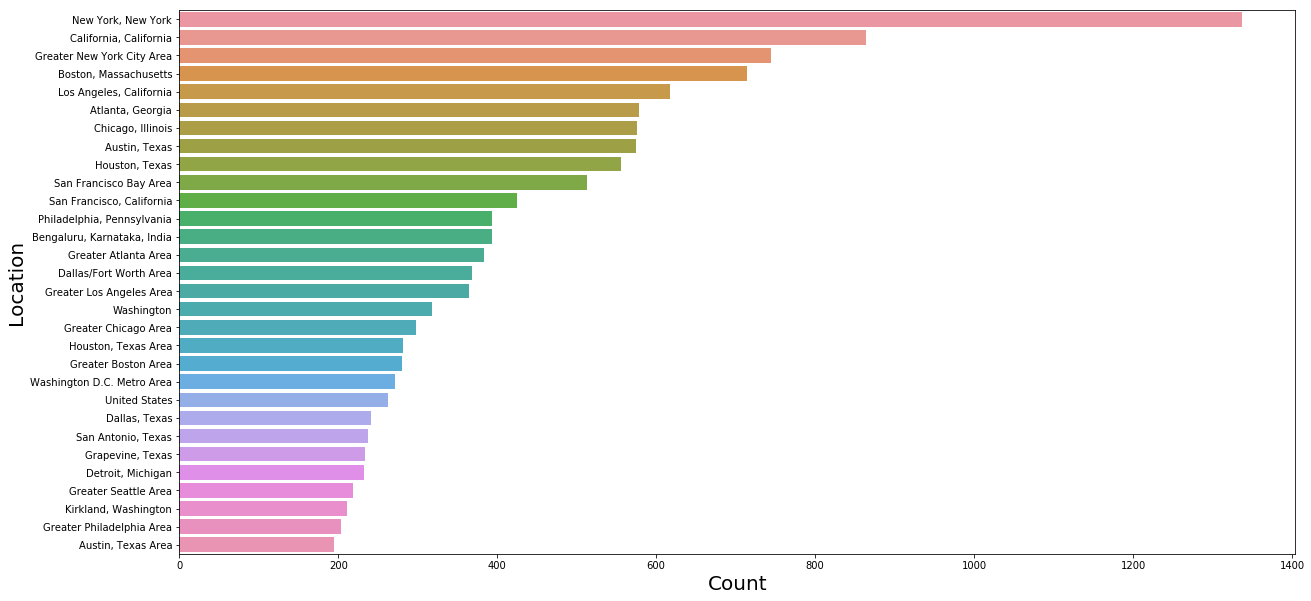

In [24]:
professionals_locations = professionals['professionals_location'].value_counts().head(30)
plt.figure(figsize=(20,10))
sns.barplot(professionals_locations.values, professionals_locations.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Location", fontsize=20)
plt.show()

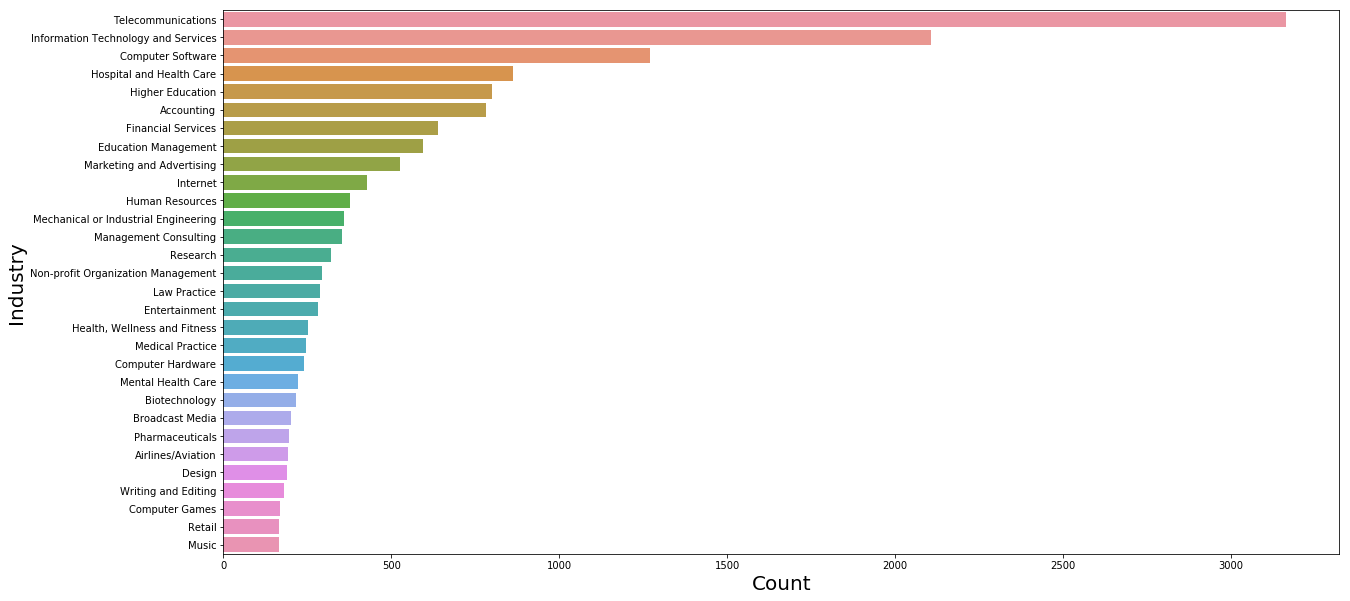

In [26]:
professionals_industries = professionals['professionals_industry'].value_counts().head(30)
plt.figure(figsize=(20,10))
sns.barplot(professionals_industries.values, professionals_industries.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Industry", fontsize=20)
plt.show()

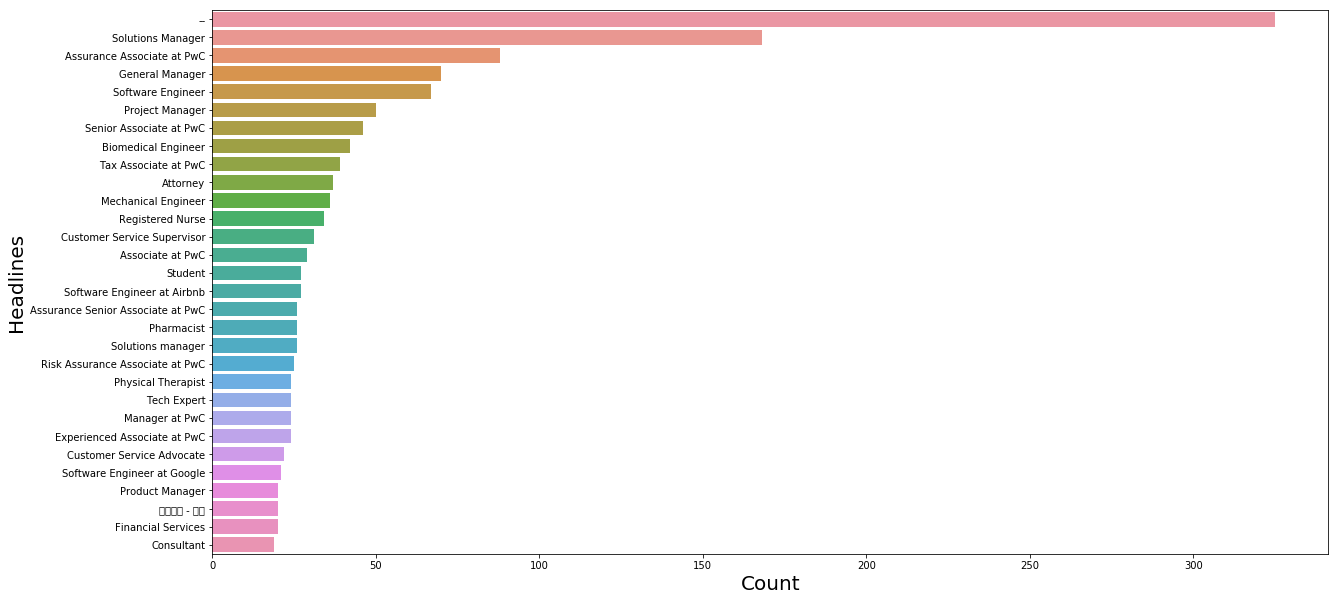

In [27]:
professionals_headlines = professionals['professionals_headline'].value_counts().head(30)
plt.figure(figsize=(20,10))
sns.barplot(professionals_headlines.values, professionals_headlines.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Headlines", fontsize=20)
plt.show()

### 2-8. Questions(핵심)

In [24]:
questions.head()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
0,332a511f1569444485cf7a7a556a5e54,8f6f374ffd834d258ab69d376dd998f5,2016-04-26 11:14:26 UTC+0000,Teacher career question,What is a maths teacher? what is a ma...
1,eb80205482e4424cad8f16bc25aa2d9c,acccbda28edd4362ab03fb8b6fd2d67b,2016-05-20 16:48:25 UTC+0000,I want to become an army officer. What can I d...,I am Priyanka from Bangalore . Now am in 10th ...
2,4ec31632938a40b98909416bdd0decff,f2c179a563024ccc927399ce529094b5,2017-02-08 19:13:38 UTC+0000,Will going abroad for your first job increase ...,I'm planning on going abroad for my first job....
3,2f6a9a99d9b24e5baa50d40d0ba50a75,2c30ffba444e40eabb4583b55233a5a4,2017-09-01 14:05:32 UTC+0000,To become a specialist in business management...,i hear business management is a hard way to ge...
4,5af8880460c141dbb02971a1a8369529,aa9eb1a2ab184ebbb00dc01ab663428a,2017-09-01 02:36:54 UTC+0000,Are there any scholarships out there for stude...,I'm trying to find scholarships for first year...


In [25]:
questions.describe()

,questions_id,questions_author_id,questions_date_added,questions_title,questions_body
count,23931,23931,23931,23931,23931
unique,23931,12329,23869,23739,23681
top,f74840697f3644009d22950d9165cafe,2fe767de78fa4dfd83f0021cf7712064,2016-05-17 22:14:06 UTC+0000,How do I become an IAS officer?,Accounting student at Towson university #acco...
freq,1,93,2,6,16


- questions랑 answers 매칭하기
- Idea 1 : questions_title에 있는 명사만 tokenizing으로 뽑아내서 professional_industry와 연결짓기?
- Idea 2 : questions_body에서 NER(개체명인식)을 통해 중요한 개체를 찾아서 TF-idf 돌리기 => 유사한 질문목록 뽑기

### 2-9. School_memberships

In [26]:
school_memberships.head()

,school_memberships_school_id,school_memberships_user_id
0,197406,23dce13ca6164a73aec7a3cd56a4884d
1,197398,23dce13ca6164a73aec7a3cd56a4884d
2,199821,23dce13ca6164a73aec7a3cd56a4884d
3,186239,9c5803ae43ca4cf6b27ea85871625116
4,182063,9c5803ae43ca4cf6b27ea85871625116


In [27]:
school_memberships.describe()

,school_memberships_school_id
count,5638.000000
mean,167256.254346
std,47588.724813
min,69421.000000
25%,125573.500000
50%,196934.000000
75%,198771.000000
max,214607.000000


### 2-10. Students

In [28]:
students.head()

,students_id,students_location,students_date_joined
0,12a89e96755a4dba83ff03e03043d9c0,NaN,2011-12-16 14:19:24 UTC+0000
1,e37a5990fe354c60be5e87376b08d5e3,NaN,2011-12-27 03:02:44 UTC+0000
2,12b402cceeda43dcb6e12ef9f2d221ea,NaN,2012-01-01 05:00:00 UTC+0000
3,a0f431fc79794edcb104f68ce55ab897,NaN,2012-01-01 05:00:00 UTC+0000
4,23aea4702d804bd88d1e9fb28074a1b4,NaN,2012-01-01 05:00:00 UTC+0000


In [29]:
students.describe()

,students_id,students_location,students_date_joined
count,30971,28938,30971
unique,30971,5480,29736
top,1027121e74a84df4ae63113d1c0c84a2,"New York, New York",2013-11-22 05:00:00 UTC+0000
freq,1,1313,246


- 학생들 location도 너무 다양하자나..? 향후에 professional이랑 같은 위치인 사람들끼리 오프라인 매칭 시켜주는 것도 좋을 듯?
- 주로 언제들 조인하는지 2시간 단위로 plot그려보기(새벽시간에 많을 것 같긴 한데)

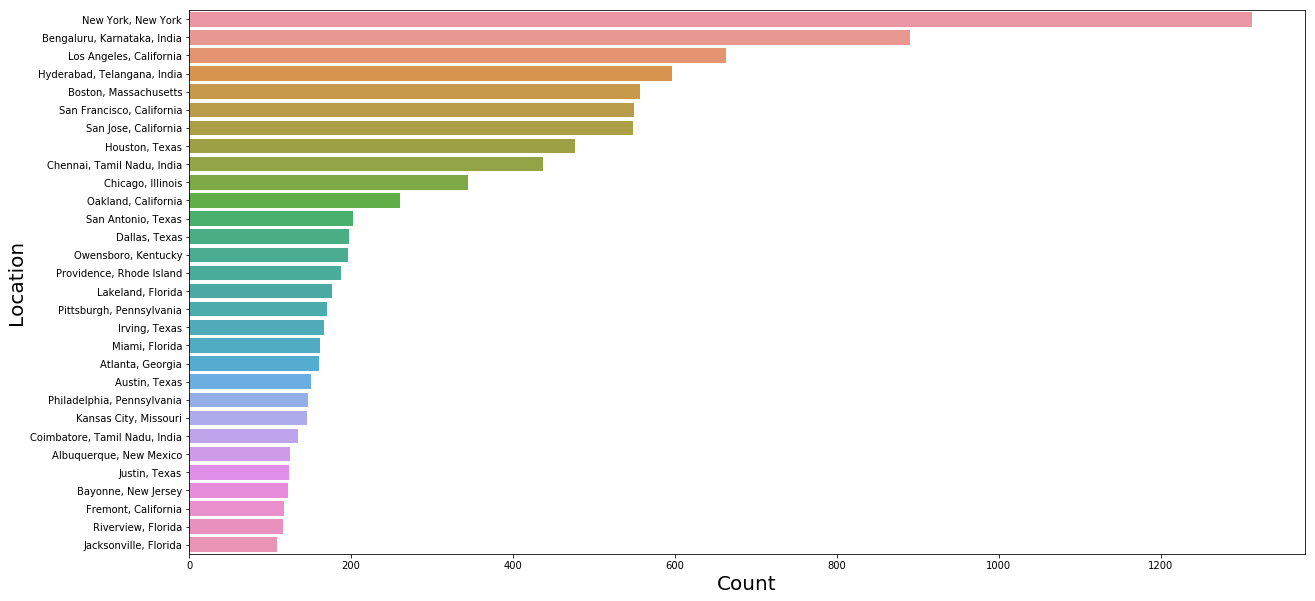

In [28]:
students_locations = students['students_location'].value_counts().head(30)
plt.figure(figsize=(20,10))
sns.barplot(students_locations.values, students_locations.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Location", fontsize=20)
plt.show()

### 2-11. Tag_questions

In [30]:
tag_questions.head()

,tag_questions_tag_id,tag_questions_question_id
0,28930,cb43ebee01364c68ac61d347a393ae39
1,28930,47f55e85ce944242a5a347ab85a8ffb4
2,28930,ccc30a033a0f4dfdb2eb987012f25792
3,28930,e30b274e48d741f7bf50eb5e7171a3c0
4,28930,3d22742052df4989b311b4195cbb0f1a


In [31]:
tag_questions.describe()

,tag_questions_tag_id
count,76553.000000
mean,17289.690763
std,10308.915329
min,27.000000
25%,11165.000000
50%,18360.000000
75%,26420.000000
max,39250.000000


### 2-12. Tag_users

In [32]:
tag_users.head()

,tag_users_tag_id,tag_users_user_id
0,593,c72ab38e073246e88da7e9a4ec7a4472
1,1642,8db519781ec24f2e8bdc67c2ac53f614
2,638,042d2184ee3e4e548fc3589baaa69caf
3,11093,c660bd0dc1b34224be78a58aa5a84a63
4,21539,8ce1dca4e94240239e4385ed22ef43ce


In [33]:
tag_users.describe()

,tag_users_tag_id
count,136663.000000
mean,18971.528629
std,9018.442845
min,27.000000
25%,18065.000000
50%,18807.000000
75%,24132.000000
max,39261.000000


### 2-13. Tags

In [34]:
tags.head()

,tags_tag_id,tags_tag_name
0,27490,college
1,461,computer-science
2,593,computer-software
3,27292,business
4,18217,doctor


In [35]:
tags.describe()

,tags_tag_id
count,16269.000000
mean,28511.686336
std,8421.414012
min,27.000000
25%,21711.000000
50%,31101.000000
75%,35207.000000
max,39276.000000


- tag 3개 테이블을 한 테이블로 합치기
- Idea: 태그들 top10으로 띄워서 웹페이지에서 해당 태그 누르면 자동으로 해당 top 질문-답변 볼 수 있게 하는 것은 어떨까?

In [78]:
tag_n_user = pd.merge(tags, tag_users, left_on='tags_tag_id', right_on='tag_users_tag_id', how='outer')
tag_n_user.sort_values('tag_users_tag_id')[:10]

,tags_tag_id,tags_tag_name,tag_users_tag_id,tag_users_user_id
32218,27,military,27.0,5f77e0a2c3a144dda336df2294a64530
32258,27,military,27.0,d688cc76ef3a4174980754fcd059392a
32259,27,military,27.0,36ddb593ca5742f29ed9b5ac66cf24a3
32260,27,military,27.0,4d0793926fe345aa958d1796c9adf5fa
32261,27,military,27.0,8963293a4dbe49619114a7cb7d76fa51
32262,27,military,27.0,642c548196e74d579e54936c633101af
32263,27,military,27.0,838988e992724d02a9130ea1b4749466
32264,27,military,27.0,56bc0e6d30864d58be216510d0e0c259
32265,27,military,27.0,6f2cc9f24a4a474a9adf385929abb592
32266,27,military,27.0,37c5c800e3934118aac2e7b020029123


In [72]:
tag_n_user.count()

tags_tag_id          141021
tags_tag_name        141020
tag_users_tag_id     136663
tag_users_user_id    136663
dtype: int64

In [82]:
tag_n_questions = pd.merge(tags, tag_questions, left_on='tags_tag_id', right_on='tag_questions_tag_id', how='outer')
tag_n_questions.sort_values('tags_tag_id')[:10]

,tags_tag_id,tags_tag_name,tag_questions_tag_id,tag_questions_question_id
34749,27,military,27.0,27cb381eea0144b7bc9dc553a9ef41b6
34651,27,military,27.0,7378c86f1e2e42cfa58e3b977a306b06
34652,27,military,27.0,4c6d71aaf2724b9f8d439ae086d4f3da
34653,27,military,27.0,3b566e9d713b49ada0c23883c084b4e4
34654,27,military,27.0,99b90ab2a92d46dda9c332cc229ea4ba
34655,27,military,27.0,50e98c8c356b4a7b9b70c5d04cf37d7d
34656,27,military,27.0,3e9b474c11654285b3e935e8b9421402
34657,27,military,27.0,5ba467d11ff34486a5b281d873450c49
34658,27,military,27.0,e0cb5a52c3a14fba81e1ad2fefcb9299
34659,27,military,27.0,03bed809e25e4b48982ba6e31ab3dabd


In [79]:
tag_n_questions.count()

tags_tag_id                  85731
tags_tag_name                85730
tag_questions_tag_id         76553
tag_questions_question_id    76553
dtype: int64

In [84]:
tag_n_questions[['tags_tag_name','tag_questions_question_id']]

,tags_tag_name,tag_questions_question_id
0,college,bfbf79503bfb48909b4e514c5675502e
1,college,a4da117f4e3b45d49b83f7c3d6bc9915
2,college,9b90fda0660e4b72936c17a642334929
3,college,37a7d709c90445fc9643ada3933fbc6d
4,college,bc854d4070dd474797ff5f0242f510f1
5,college,b3f8dc8bb99b45c6a6898b7ea20daf6c
6,college,2fceaae061a745728d59c858670ad095
7,college,a13642cafac5475c8ba7012e13e06b28
8,college,4c521ed278a3450b995d8218aeae2da9
9,college,81fe26c0f4214d70b1c0875f3a4720a0


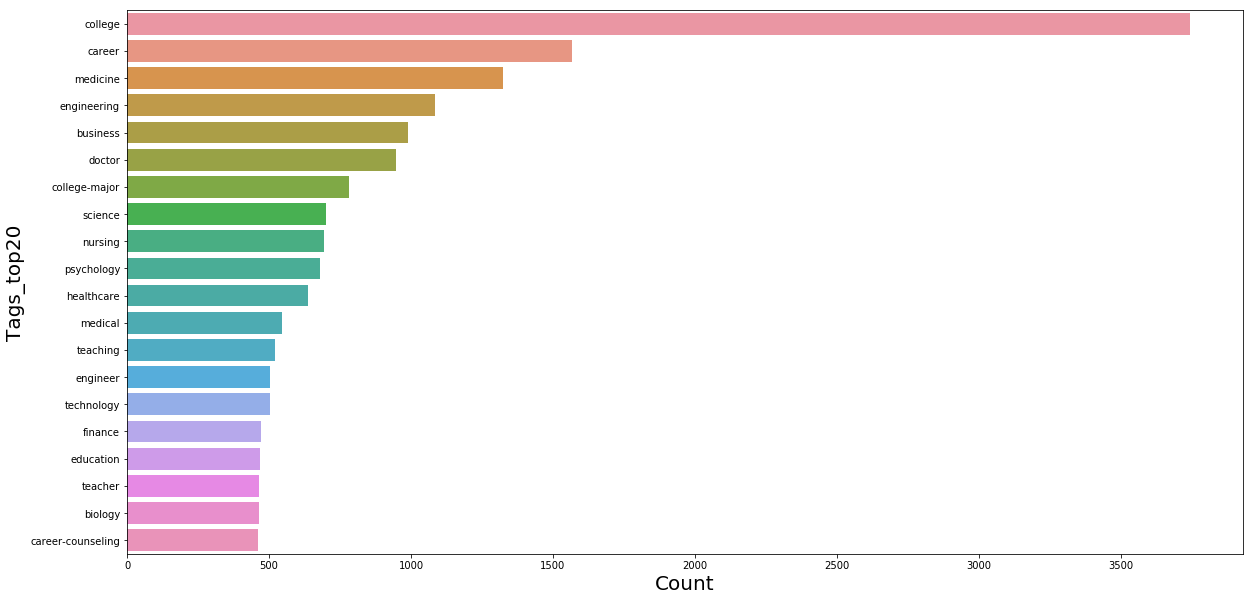

In [87]:
tags_top20 = tag_n_questions['tags_tag_name'].value_counts().head(20)
plt.figure(figsize=(20,10))
sns.barplot(tags_top20.values, tags_top20.index)
plt.xlabel("Count", fontsize=20)
plt.ylabel("Tags_top20", fontsize=20)
plt.show()

### 3.  <a id="analyze"> Analyzing </a>

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.corpus import words

vectorizer = CountVectorizer(analyzer = 'word', 
                             lowercase = True,
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3),
                             vocabulary = set(words.words()), # nltk의 words를 사용하거나 문서 자체의 사전을 만들거나 선택한다. 
                             max_features = 90000
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=90000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary={'ponticular', 'sniggering', 'Dorism', 'Ephesian', 'undesirability', 'aranein', 'faith', 'eliquation', 'fribbling', 'bilamellar', 'ass', 'flecnode', 'raviney', 'frustrate', 'azthionium', 'zoarial', 'hogherd', 'epithelial', 'farweltered', 'ouistiti', 'semifamine', 'sensationless', 'ungarte..., 'poppet', 'broiderer', 'miaul', 'passivist', 'unbailable', 'quadrupleness', 'friendliness', 'Kim'})

In [30]:
pipeline = Pipeline([
    ('vect', vectorizer),
    ('tfidf', TfidfTransformer(smooth_idf = False)),
])  
pipeline

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=90000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
       ...('tfidf', TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True))])

In [33]:
# 우선 answers를 보자
%time answer_train_tfidf_vector = pipeline.fit_transform(answers['answers_body'].values.astype('U'))  

C:\Users\lady1\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1242: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


Wall time: 30.1 s


In [34]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

235892


['A',
 'Aani',
 'Aaron',
 'Aaronic',
 'Aaronical',
 'Aaronite',
 'Aaronitic',
 'Aaru',
 'Ab',
 'Ababdeh']

In [36]:
import numpy as np
dist = np.sum(answer_train_tfidf_vector, axis=0)

for tag, count in zip(vocab, dist):
    print(count, tag)

pd.DataFrame(dist, columns=vocab)

[[0. 0. 0. ... 0. 0. 0.]] A


,A,Aani,Aaron,Aaronic,Aaronical,Aaronite,Aaronitic,Aaru,Ab,Ababdeh,...,zymotechnical,zymotechnics,zymotechny,zymotic,zymotically,zymotize,zymotoxic,zymurgy,zythem,zythum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#### from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=2018)
forest

NameError: name 'RandomForestClassifier' is not defined

### 4.  <a id="analyze2"> Analyze </a>

#### 190331 ~ 190401
- [(1)](#190331-1) 여러개의 answer중에 적절한 answer는? → 1대1인 것만 뽑아서 해보자. 
- [(2)](#190331-2) professionals의 industry와 headline 데이터를 나름의 카테고리로 전처리한다.
- [(3)](#190331-3) Answer의 Text를 TF-idf(문장 내에 단어 가중치를 준다) & tokenizing(Reference 찾아보기로) → 하여 Answer의 명사만 뽑는다. 

<a id='190331-1'> (1) </a> 여러개의 answer중에 적절한 answer는? → 1대1인 것만 뽑아서 해보자. 
- 일단 가장 먼저 있는 값으로 대응시키자

In [55]:
# questions.questions_id = answers.answers_question_id

Q_n_A = pd.merge(questions[['questions_id','questions_title','questions_body']], answers[['answers_question_id','answers_id','answers_body']], left_on='questions_id', right_on='answers_question_id', how='outer')
Q_n_A.sort_values('questions_id')

# inner(NaN 제외) : questions_id = (51123) 23931, answers_id = 51123
# outer(NaN 포함) : questions_id = (51944) 23931, answers_id = 51123

,questions_id,questions_title,questions_body,answers_question_id,answers_id,answers_body
12793,0003e7bf48f24b5c985f8fce96e611f3,Does doing double major in tech academy at Hig...,I am a Junior in H.S. right now i am thinking ...,0003e7bf48f24b5c985f8fce96e611f3,2c2e764ce4ae416fa0145ee999bb424c,"<p>Hey Sahil, great question! I think it's abs..."
12792,0003e7bf48f24b5c985f8fce96e611f3,Does doing double major in tech academy at Hig...,I am a Junior in H.S. right now i am thinking ...,0003e7bf48f24b5c985f8fce96e611f3,96a353d918584104921b82a607620711,<ol><li>Get a list of the intership companies ...
435,0006609dd4da40dcaa5a83e0499aba14,Should I declare a minor during undergrad if I...,"I'm currently an undergrad, but I want to go t...",0006609dd4da40dcaa5a83e0499aba14,f4e74694fc534db387541105197178c9,"Alex, lawyers deal with every aspect of human ..."
434,0006609dd4da40dcaa5a83e0499aba14,Should I declare a minor during undergrad if I...,"I'm currently an undergrad, but I want to go t...",0006609dd4da40dcaa5a83e0499aba14,23a89b4dc6124dabb591b2da3d6eeea3,<p>Psychology would indeed be a useful minor f...
433,0006609dd4da40dcaa5a83e0499aba14,Should I declare a minor during undergrad if I...,"I'm currently an undergrad, but I want to go t...",0006609dd4da40dcaa5a83e0499aba14,a8b9a1ef128e4798916f4b03fb66ccfa,"<p>Alex, short answer is yes, you should decla..."
46744,000af224bc2f4e94a19f8b62ba279cc4,How do I get a job in my prefered field,"So what if you have the degree, what do you do...",000af224bc2f4e94a19f8b62ba279cc4,a448a27fca8d40a08cf1722f44cf7825,"<p>Hi Tessa,</p>\n<p>A question many people en..."
50679,000b30fb534b41f7b716fa9ebf9c3f35,Is the Demand for Gym Teachers diminishing?,"Hi, I'm currently debating on whether to pursu...",000b30fb534b41f7b716fa9ebf9c3f35,987a377658c0439a8f1e74117531eb2a,"<p>Hello David,</p>\n<p>I hope you are doing g..."
50680,000b30fb534b41f7b716fa9ebf9c3f35,Is the Demand for Gym Teachers diminishing?,"Hi, I'm currently debating on whether to pursu...",000b30fb534b41f7b716fa9ebf9c3f35,9e0668ad18444fd3a30687249a0b655b,"<p>First, if becoming a gym teacher is your pa..."
3601,0018752e44b44e26bb74a0a43232b4d6,How does an aspiring mathematician stay motiva...,Hi! I am a high school senior set on becoming ...,0018752e44b44e26bb74a0a43232b4d6,6c41fd92dba046b59f750924ff54aa9c,<p>Definitely read the book and watch the movi...
248,0025b917219c4a24ba5fe260ca66ca98,what are the top colleges for forensic science?,i watch a lot of tv and my favorite show is cr...,0025b917219c4a24ba5fe260ca66ca98,f9390f8f2e4a40f9876ba0d81604734a,<html><head></head><body><p>Hi Ariana--I think...


In [52]:
Q_n_A.describe()

,questions_id,questions_title,questions_body,answers_question_id,answers_id,answers_body
count,51944,51944,51944,51123,51123,51122
unique,23931,23739,23681,23110,51123,50401
top,8eb6ba7af57846acbfec5633e537192a,What qualities should I possess if I want to b...,Accounting student at Towson university #acco...,8eb6ba7af57846acbfec5633e537192a,088ed1a3b265486d937208248671a314,"<p>&lt;span style=""background-color: transpare..."
freq,58,58,58,58,1,103


<a id='190331-2'> (2) </a> professionals의 industry와 headline 데이터를 나름의 카테고리로 전처리한다.
- Answer의 author_id와 professinals_id Mapping 
- 개채명 인식을 해야 answers에서 한 단어로 나올 것 같다..
- 일단 frequency로 가중치 줘서 나오게 해야 하는가?!

In [61]:
# professionals.professionals_id = answers.answers_author_id

Professionals_ID = pd.merge(professionals[['professionals_id','professionals_industry','professionals_headline']], answers[['answers_author_id','answers_id','answers_body']], left_on='professionals_id', right_on='answers_author_id', how='outer')
Professionals_ID.sort_values('professionals_id')

Professionals_ID

# inner(NaN 제외) : professionals_id = (50106) 10067, answers_author_id = (50106) 10067
# outer(NaN 포함) : professionals_id = (68191) 28152, answers_author_id = (51123) 10169

### industry와 headline의 NaN값을 answers의 명사로 임의로 채워줘야 함

,professionals_id,professionals_industry,professionals_headline,answers_author_id,answers_id,answers_body
0,9ced4ce7519049c0944147afb75a8ce3,NaN,NaN,9ced4ce7519049c0944147afb75a8ce3,7640a6e5d5224c8681cc58de860858f4,<p>Basically three things: </p>\n<ol>\n<li>Big...
1,f718dcf6d2ec4cb0a52a9db59d7f9e67,NaN,NaN,NaN,NaN,NaN
2,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,f18d7fca363d4b21a81e6683c5a86b96,"<html><head></head><body><p>Hi Deja,</p>\n<p>K..."
3,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,5d670d5f8700402ab56bae609b06d02d,<html><head></head><body><p>It looks like this...
4,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,6d823a750e294c75b10fafbbbaf19855,<p><em>[Posted on behalf of a CareerVillage Pr...
5,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,63b7a06323ee4d578a37cf780debfa58,"<p>Yes, early in your career, employers certai..."
6,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,7f479cd7140e4954b838d7197b7791c3,<html><head></head><body><p>Take a look at thi...
7,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,97eba893d7084b798575e13e39f774ae,<html><head></head><body><p>Hi Timothy--this q...
8,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,026de338c3574f17ad0f5898527b5698,"<html><head></head><body><p><a href=""http://ww..."
9,0c673e046d824ec0ad0ebe012a0673e4,NaN,NaN,0c673e046d824ec0ad0ebe012a0673e4,0f5615fcffb349d9b07e9a714d0573dc,<p>[The following answer is from a 2004 Olympi...


In [62]:
Professionals_ID.describe()

,professionals_id,professionals_industry,professionals_headline,answers_author_id,answers_id,answers_body
count,68191,61937,64184,51123,51123,51122
unique,28152,2470,22272,10169,51123,50401
top,36ff3b3666df400f956f8335cf53e09e,Telecommunications,Assist with Recognizing and Developing Potential,36ff3b3666df400f956f8335cf53e09e,088ed1a3b265486d937208248671a314,"<p>&lt;span style=""background-color: transpare..."
freq,1710,5801,1710,1710,1,103


<a id='190331-3'> (3) </a> Q_n_A의 Text를 TF-idf(문장 내에 단어 가중치를 준다) & tokenizing-Vectorizing → 하여 Answer의 명사만 뽑는다. 
- Answers_body의 html 코드 제외한 순문장을 corpus에 넣음
- gensim.summarization 패키지로 Summarization & Keywords 뽑기 실행(Top 3 뽑을 수 있는지 파라미터 확인)

In [91]:
Professionals_ID.answers_body[0]

'<p>Basically three things: </p>\n<ol>\n<li>Big brand name employers or schools</li>\n<li>Academic performance (GPA)</li>\n<li>Evidence of leadership and people management skills</li>\n</ol>\n<p><strong>1) Big Brand Name Employers or Schools</strong><br>\nIf you\'re an Associate making $150,o00 – $200,000 USD per year, your employer is probably billing you out to clients at $600,000 USD/year.  That\'s $50,000 USD/month. The client is going to want to know what and who they are getting for that kind of money. When the answer is John or Jane Doe, who has a BS from Dartmouth, a MD from Yale and MBA from Harvard, clients respond with an "Oh wow… that\'s impressive" comment.  It makes it easier to get new clients to say "yes". Now plenty of people get into the top firms (McKinsey included) that do NOT have such a perfect ivy pedigree… but if you got it, make sure it is OBVIOUS (it will help a lot).</p>\n<p>Let me explain the thought process some of these biases.  The thinking is that only s

In [109]:
len(Professionals_ID.answers_body)

69208

In [122]:
Answers_Text = re.sub('<.+?>', '', Professionals_ID.answers_body[0], 0, re.I|re.S)
Answers_Text = re.split('\n', Answers_Text)
Answers_Text

['Basically three things: ',
 '',
 'Big brand name employers or schools',
 'Academic performance (GPA)',
 'Evidence of leadership and people management skills',
 '',
 '1) Big Brand Name Employers or Schools',
 'If you\'re an Associate making $150,o00 – $200,000 USD per year, your employer is probably billing you out to clients at $600,000 USD/year.  That\'s $50,000 USD/month. The client is going to want to know what and who they are getting for that kind of money. When the answer is John or Jane Doe, who has a BS from Dartmouth, a MD from Yale and MBA from Harvard, clients respond with an "Oh wow… that\'s impressive" comment.  It makes it easier to get new clients to say "yes". Now plenty of people get into the top firms (McKinsey included) that do NOT have such a perfect ivy pedigree… but if you got it, make sure it is OBVIOUS (it will help a lot).',
 'Let me explain the thought process some of these biases.  The thinking is that only super high achievers get into the top schools… and

In [123]:
str(Answers_Text)

'[\'Basically three things: \', \'\', \'Big brand name employers or schools\', \'Academic performance (GPA)\', \'Evidence of leadership and people management skills\', \'\', \'1) Big Brand Name Employers or Schools\', \'If you\\\'re an Associate making $150,o00 – $200,000 USD per year, your employer is probably billing you out to clients at $600,000 USD/year.  That\\\'s $50,000 USD/month. The client is going to want to know what and who they are getting for that kind of money. When the answer is John or Jane Doe, who has a BS from Dartmouth, a MD from Yale and MBA from Harvard, clients respond with an "Oh wow… that\\\'s impressive" comment.  It makes it easier to get new clients to say "yes". Now plenty of people get into the top firms (McKinsey included) that do NOT have such a perfect ivy pedigree… but if you got it, make sure it is OBVIOUS (it will help a lot).\', \'Let me explain the thought process some of these biases.  The thinking is that only super high achievers get into the 

In [113]:
stopwords = nltk.corpus.stopwords.words('english')

word_frequencies = {}  
for word in nltk.word_tokenize(Answers_Text[0]):  
    if word not in stopwords:
        if word not in word_frequencies.keys():
            word_frequencies[word] = 1
        else:
            word_frequencies[word] += 1

In [133]:
from gensim.summarization import summarize # 문장을 요약해주는 라이브러리!!
from gensim.summarization import keywords # 키워드 뽑아주는 라이브러리~!

print("1. Summarizing :", '\n', summarize(str(Answers_Text)), '\n')
print("######################################################################################################", '\n')
print("2. Keywords :", '\n', keywords(str(Answers_Text)))

## 오오 keywords는 lemmentation 해주면 되겠답!

1. Summarizing : 
 ['Basically three things: ', '', 'Big brand name employers or schools', 'Academic performance (GPA)', 'Evidence of leadership and people management skills', '', '1) Big Brand Name Employers or Schools', 'If you\'re an Associate making $150,o00 – $200,000 USD per year, your employer is probably billing you out to clients at $600,000 USD/year.
It is easier to understand a candidate's accomplishment via the implied credibility of the employer name and it is also easier to convey to clients.", 'It is the same reason everyone wants to work for MBB – McKinsey, Bain or Boston Consulting Group — it implies something on your resume that stays with you forever.
It stays with you for a very long time.', '2) Academic Performance (GPA)', 'The top firms want to know if you are smart.
If yours is different or you are applying from one country to an office in a different country, then you want to put on your resume some way for the reader to interpret your GPA (put your rank or put 

In [106]:
from sklearn.feature_extraction.text import CountVectorizer # 일반 갯수 Vectorizer
import nltk

vect = CountVectorizer(tokenizer = nltk.word_tokenize).fit(Answers_Text) #nltk 토크나이저로 tokenizing하고 Vectorizing
vect.vocabulary_

{'basically': 63,
 'three': 329,
 'things': 324,
 ':': 23,
 'big': 67,
 'brand': 71,
 'name': 225,
 'employers': 115,
 'or': 245,
 'schools': 287,
 'academic': 30,
 'performance': 255,
 '(': 7,
 'gpa': 146,
 ')': 8,
 'evidence': 121,
 'of': 236,
 'leadership': 198,
 'and': 45,
 'people': 251,
 'management': 211,
 'skills': 293,
 '1': 11,
 'if': 170,
 'you': 370,
 "'re": 5,
 'an': 43,
 'associate': 58,
 'making': 210,
 '$': 1,
 '150': 13,
 ',': 9,
 'o00': 234,
 '–': 373,
 '200,000': 15,
 'usd': 342,
 'per': 253,
 'year': 368,
 'your': 371,
 'employer': 114,
 'is': 188,
 'probably': 259,
 'billing': 69,
 'out': 248,
 'to': 332,
 'clients': 82,
 'at': 60,
 '600,000': 22,
 'usd/year': 344,
 '.': 10,
 'that': 318,
 "'s": 6,
 '50,000': 20,
 'usd/month': 343,
 'the': 319,
 'client': 81,
 'going': 144,
 'want': 351,
 'know': 197,
 'what': 357,
 'who': 360,
 'they': 323,
 'are': 53,
 'getting': 141,
 'for': 134,
 'kind': 195,
 'money': 221,
 'when': 358,
 'answer': 46,
 'john': 194,
 'jane': 19

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer # 문서 가중치 Vertorizer

tfidv = TfidfVectorizer(tokenizer = nltk.word_tokenize).fit(Answers_Text)
#tfidv.transform(Answers_Text).toarray() # vertor값 보기
tfidv.vocabulary_

{'basically': 63,
 'three': 329,
 'things': 324,
 ':': 23,
 'big': 67,
 'brand': 71,
 'name': 225,
 'employers': 115,
 'or': 245,
 'schools': 287,
 'academic': 30,
 'performance': 255,
 '(': 7,
 'gpa': 146,
 ')': 8,
 'evidence': 121,
 'of': 236,
 'leadership': 198,
 'and': 45,
 'people': 251,
 'management': 211,
 'skills': 293,
 '1': 11,
 'if': 170,
 'you': 370,
 "'re": 5,
 'an': 43,
 'associate': 58,
 'making': 210,
 '$': 1,
 '150': 13,
 ',': 9,
 'o00': 234,
 '–': 373,
 '200,000': 15,
 'usd': 342,
 'per': 253,
 'year': 368,
 'your': 371,
 'employer': 114,
 'is': 188,
 'probably': 259,
 'billing': 69,
 'out': 248,
 'to': 332,
 'clients': 82,
 'at': 60,
 '600,000': 22,
 'usd/year': 344,
 '.': 10,
 'that': 318,
 "'s": 6,
 '50,000': 20,
 'usd/month': 343,
 'the': 319,
 'client': 81,
 'going': 144,
 'want': 351,
 'know': 197,
 'what': 357,
 'who': 360,
 'they': 323,
 'are': 53,
 'getting': 141,
 'for': 134,
 'kind': 195,
 'money': 221,
 'when': 358,
 'answer': 46,
 'john': 194,
 'jane': 19

#### 190401

- [(4)](#190401-4) 2번에서 전처리한 Answer의 Text를 Input data, 1번에서 전처리한 professionals의 카테고리를 target으로 하여 예측모델을 생성
- [(5)](#190401-5) 예측 모델로 professionals의 industry와 headline의 NA 값을 예측한다. (NA 값 처리 → Softmax(Classifier))
- [(6)](#190401-6) Questions + tags(정규표현식으로 전처리)를 조합(어떻게 조합할지도 고민)하여 questions의 Text를 TF-idf
    => (문장 내에 단어 가중치를 준다) & tokenizing 하여 키워드를 추출한다.
- [(7)](#190401-7) 추출된 키워드가 input, professionals의 industry와 headline이 target 값으로 하여 분류기 생성 (어떤 모델일지는 더 고민)

<a id='190401-4'> (4) </a> 2번에서 전처리한 Answer의 Text를 Input data, 1번에서 전처리한 professionals의 카테고리를 target으로 하여 예측모델을 생성 
- 카테고리가 넘나 방대함. 카테고리를 축소시켜야 함(대중소분류든 뭐든)

<a id='190401-5'> (5) </a> 예측 모델로 professionals의 industry와 headline의 NA 값을 예측한다. (NA 값 처리 → Softmax(Classifier))
- 카테고리 축소되면 knn_impute or mice

<a id='190401-6'> (6) </a> Questions + tags(정규표현식으로 전처리)를 조합(어떻게 조합할지도 고민)하여 questions의 Text를 TF-idf => (문장 내에 단어 가중치를 준다) & tokenizing 하여 키워드를 추출한다.

- 얘는 그냥 gensim 하면 될 듯

<a id='190401-7'> (7) </a> 추출된 키워드가 input, professionals의 industry와 headline이 target 값으로 하여 분류기 생성 (어떤 모델일지는 더 고민)
- svm부터 돌려봅시당